In [2]:
import numpy as np
from sklearn.preprocessing import normalize
import networkx as nx
import matplotlib.pyplot as plt
import copy
import random
import pprint
from mpl_toolkits.mplot3d import Axes3D

In [3]:
edges_all = np.genfromtxt('epinions.csv', delimiter=',').astype(int) # dataset from https://snap.stanford.edu/data/soc-Epinions1.html
nodes_all = np.around(np.unique(edges_all[:,0]))

G = nx.Graph()
G.add_nodes_from(nodes_all)
G.add_edges_from(edges_all)

In [4]:
# Choosing a ego-subgraph of node n and radius 1
H = nx.ego_graph(G, n=1, radius=1, center=True, undirected=False, distance=None)
nodes = H.nodes()
edges = H.edges()

In [5]:
#Defining functions to create opinion dynamical model

#Randomly initializing opinion of an agent
def rand_ini(num_elem):
    p_ = np.random.rand(num_elem).reshape(1,-1).astype(np.float64)
    p = normalize(p_, norm='l1')
    return p

#Setting a rule of interaction between agents
#Simple conflict, adding a product of two opinions
def conflict_simple(p,r):
    p_ = np.multiply(p,(1 + r))
    return normalize(p_, norm='l1') 

#Conflict with tau, adding mininal value
def conflict_tau(p,r):
    tau = np.minimum(p,r)
    p_ = np.add(p,tau)
    return normalize(p_, norm='l1') 
        
#Computing average neughbour opinion
def av_neighbor_op(G, node, agents_set):
    s = np.zeros(num_elem)
    neighborhood = G.neighbors(node)
    for neighbor in neighborhood:
        for agent in agents_set:
            if neighbor == agent:
                s = np.add(s,agents_set[agent])
    return s / len(neighborhood)
   
#Round up all agents' opinions two 2 decimals
def round_(agents_set):
    labels = {}
    for node in nodes:
        labels[node] = np.around(agents_set[node], decimals=2)
    return labels

#Creating labels to print on the graph
def round_labels(agents_set):
    labels = round_(agents_set)
    lab = {}
    for l in labels:
        lst = [str(i) for i in labels[l]]
        lab[l] = ''.join(lst)
    return lab

#Creating groups of agents according to their opinions 
def coloring_nodes(agents_set, nodes):
    red_nodes = []
    blue_nodes = []
    green_nodes = []
    grey_nodes = []
    av = 1/num_elem
    eps = 0.001
    labels = round_(agents_set)
    for node in nodes:
        max_val = np.max(labels[node])
        arg = np.argmax(labels[node])
        if np.absolute(max_val-av) < eps:
            grey_nodes.append(node)
        else: 
            if arg == 0:
                red_nodes.append(node)
            if arg == 1:
                blue_nodes.append(node)
            if arg == 2:
                green_nodes.append(node)
                
    return grey_nodes, green_nodes, red_nodes, blue_nodes

#Drawing the graph
def drawing_graph(G, pos, coloring, file_name):
    #labels = round_labels(agents_set)
    fig=plt.figure(figsize=(20, 15))
    nx.draw_networkx_nodes(G,pos,nodelist=coloring[0], node_color='yellow')
    nx.draw_networkx_nodes(G,pos,nodelist=coloring[1], node_color='green')
    nx.draw_networkx_nodes(G,pos,nodelist=coloring[2], node_color='red')
    nx.draw_networkx_nodes(G,pos,nodelist=coloring[3], node_color='blue')
    nx.draw_networkx_edges(G,pos,edgelist=G.edges(), alpha=0.2, edge_color='grey')
    #nx.draw_networkx_labels(G,pos,labels,font_size=12)
    #plt.savefig(file_name,dpi=100)
    plt.show()
    plt.close()
    

In [6]:
#Applying tau conflict N times (N=number). An agent interacts with the average opinion of the whole group.
#Drawing the resulting graph
def mean_field_iterations(number, H, nodes, agents_set, pos):
    #pos=nx.spring_layout(H)
    #pos = nx.random_layout(H)
    #drawing_graph(H, pos, coloring_nodes(agents_set, nodes), "mean_field_plus.png")
    neighbors_opinion = {}
    for i in range(number):
        for node in nodes:
            neighbors_opinion[node] = av_neighbor_op(H, node, agents_set)        
        for node in nodes:
            agents_set[node] = conflict_tau(agents_set[node], neighbors_opinion[node])
        #file_name = "mean_field_plus"+str(i+1)+".png"
    file_name=''
    drawing_graph(H, pos, coloring_nodes(agents_set, nodes), file_name)
        

In [7]:
#Applying simple conflict N times (N=number). A ramdomly chosen agent interacts with another randomly chosen agent.
#Drawing the resulting graph
def iterations(number, H, nodes, agents_set, pos):
    #drawing_graph(H, pos, coloring_nodes(agents_set, nodes), "plus.png")
    for i in range(number):
        agents_temp = {}
        for node in nodes:
            neighbor = np.random.choice(H.neighbors(node))
            agents_temp[node] = conflict_tau(agents_set[node], agents_set[neighbor])
        agents_set = copy.deepcopy(agents_temp)
    file_name = '' #"plus"+str(i+1)+".png"
    drawing_graph(H, pos, coloring_nodes(agents_set, nodes), file_name)
    return agents_temp
  

In [8]:
num_elem = 3 # number of agent's opinions to study 
# initializing a set of agents with randomly set opinions
degrees = H.degree(nodes)
agents = {}

for node in nodes:
    agents[node] = rand_ini(num_elem)
    
agents_complete = {}
agents_check = {}
agents_complete = copy.deepcopy(agents)
agents_check = copy.deepcopy(agents)

pos = nx.random_layout(H)

In [12]:
s = np.zeros(num_elem)
s1 = np.zeros(num_elem)
tau = agents[1]
for agent in agents:
    s = np.add(s,agents[agent])
    s1 = np.add(s1,agents[agent]*degrees[agent])
    tau = np.minimum(tau,agents[agent])
    
print("s = ", normalize(s, norm='l1'))
print("s1 = ", normalize(s1, norm='l1'))
print("tau = ", tau)

s =  [[ 0.33223462  0.33542823  0.33233715]]
s1 =  [[ 0.32825887  0.33442515  0.33731598]]
tau =  [[ 0.00071987  0.00029181  0.00185453]]


In [ ]:
#mean_field_iterations(1000, H, nodes, agents, pos)

In [ ]:
#pprint.pprint(agents[1])

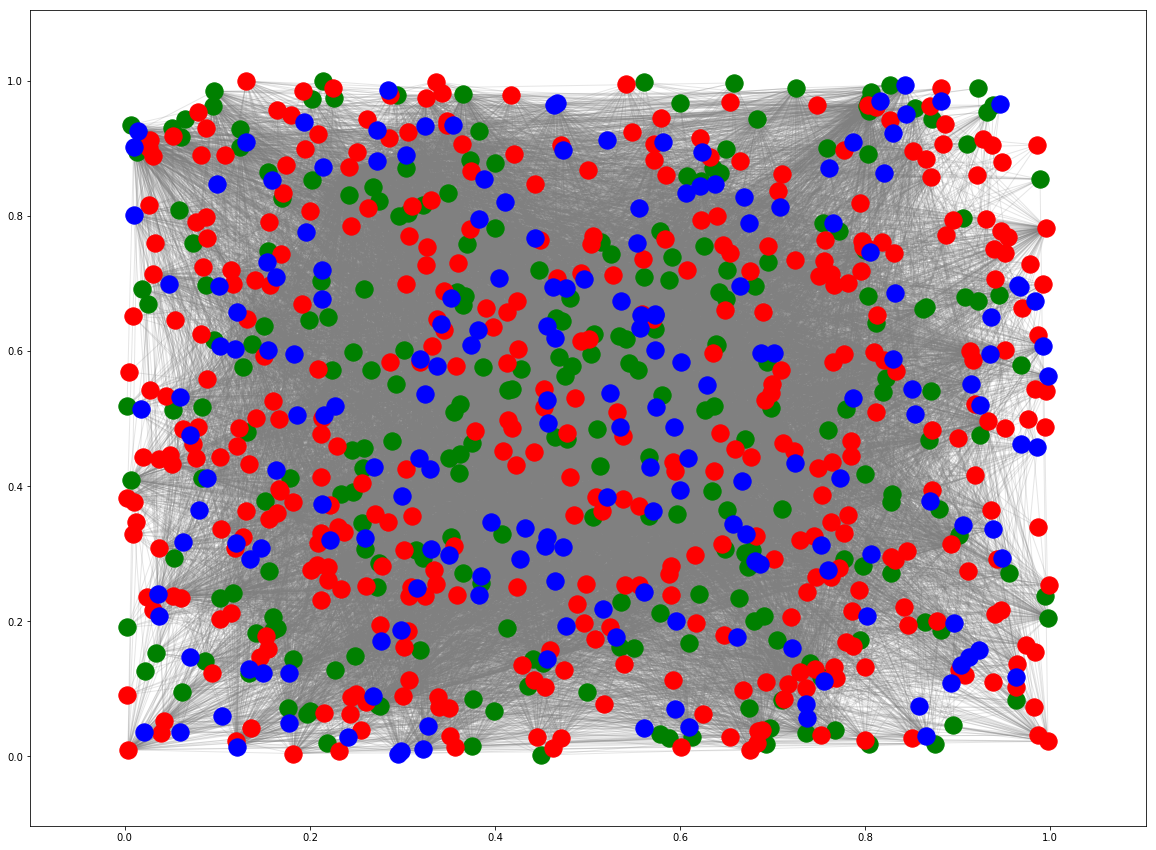

In [13]:
a_set = iterations(20, H, nodes, agents_random, pos)

In [11]:
pprint.pprint(agents[1])


array([[ 0.67168409,  0.17229986,  0.15601605]])


In [ ]:
C=nx.complete_graph(len(nodes))
fig=plt.figure(figsize=(20, 15))
pos = nx.random_layout(C)
nx.draw_networkx_nodes(C, pos)
nx.draw_networkx_edges(C, pos, alpha=0.2, edge_color='grey')
plt.show()
plt.close()

In [ ]:
t1 = np.ones(3)
s = np.zeros(3)
for (u,v) in edges:
    tau = normalize(np.minimum(agents[u],agents[v]), norm='l1')
    t1 = normalize(np.minimum(t1,tau), norm='l1')
    s = normalize(np.add(s,tau), norm='l1')
print(s)

In [ ]:
nx.relabel_nodes(C,dict(enumerate(np.sort(nodes))), copy = False)

mean_field_iterations(10, C, nodes, agents_complete, pos)

In [ ]:
nx.relabel_nodes(C,dict(enumerate(np.sort(nodes))), copy = False)

mean_field_iterations(10, C, nodes, agents_complete, pos)

In [ ]:
X = []
Y = []
Z = []
for agent in agents_check:
    X.append(agents_check[agent][0,0])    
    Y.append(agents_check[agent][0,1])    
    Z.append(agents_check[agent][0,2])
    
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 45)
ax.set_xlim3d(0, 1.0)
ax.set_ylim3d(0,1.0)
ax.set_zlim3d(0,1.0)
ax.scatter(X, Y, Z)
plt.show()
